### KAGGLE - TITANIC PROBLEM 

IMPORTING REQUIRED LIBRARIES AND PACKAGES: 

In [350]:
# Import Dependencies
%matplotlib inline

# data analysis and wrangling
import math, time, random, datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')                        # The default theme is DarkGrid Theme .........

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


In [351]:
#IMPORTING THE DATABASE (TRAINING AS WELL AS TESTING) and Submission format
df_train = pd.read_csv('Downloads/train.csv')
df_test = pd.read_csv('Downloads/test.csv')
gender_submission = pd.read_csv('Downloads/gender_submission.csv') 

In [352]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [353]:
#df_both will be useful when we need to perform operations on both the datasets simultaneously 
df_both = [df_train, df_test]

Here the features that are available in the dataset are as follows: 
<br>
1 PassengerId <br>
2 Pclass <br>
3 Name <br>
4 Sex <br>
5 Age <br>
6 SibSp <br>
7 Parch <br>
8 Ticket <br>
9 Fare <br>
10 Cabin <br> 
11 Embarked <br>

Now the first task is to seperate the data as per it's type : 
<br>
Categorical
<br>
Numerical 
<br>
Doubtful

Categorical : Name, Sex, Ticket, Cabin, Embarked
<br>
Numerical : PassengerId, Age, SibSp, Parch, Fare, Survived, Pclass

Now we are targetting to estimate the target variable: Survived and hence we will remove it from the consideration for now. 

In [354]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Now we need to think about the data which is unavailable. 

In [355]:
df_train.info()
print('_'*40)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Passenger

We can clearly see that Cabin feature is less than 50% in terms of availability. Hence its better to mark it out of consideration. 

In [356]:
df_train['Age'].isnull().values.any()

True

In [357]:
#Now let us check for the uniqueness of the database
df_train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Hart, Mr. Benjamin",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


There are duplicate values present in ticket section, which indicates that it should also be removed from our consideration (even intuitively, ticket name shall not be affecting the survivor, though now we have numbers to support our intuition)

Hence the features that we shall take into consideration are : Sex, Embarked, Age, Pclass, Parch, SibSp, Fare

We will also need to complete or adjust the features which are missing but do play an important role in preparing our model like Age and Embarked. But first lets analyze the variables and get better insight with their effects on survival. 

In [358]:
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


We can see that 1st class people have a better chance of survival than 2nd/3rd class. 

In [359]:
df_train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)                      

,Sex,Survived
0,female,0.742038
1,male,0.188908


Females are having better survival chance in comparision to males. 

In [360]:
df_train[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


Correlation is not linear !  

In [361]:
df_train[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


Correlation is not linear !

ANALYSING DATA: 

0    549
1    342
Name: Survived, dtype: int64


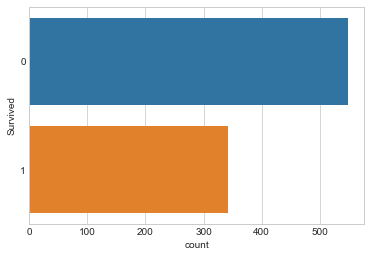

In [362]:
#fig = plt.figure(figsize=(20,1))
sns.countplot(y='Survived', data=df_train);
print(df_train.Survived.value_counts())

Total Number of Survivors are 342, approximately 38 percent of the total passengers. 

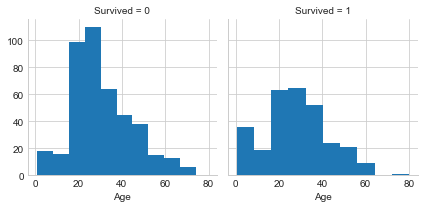

In [363]:
graph = sns.FacetGrid(df_train, col='Survived')
graph.map(plt.hist, 'Age', bins=10)

Observation: People in between the age of 20 to 40 are the ones who survived the most. 

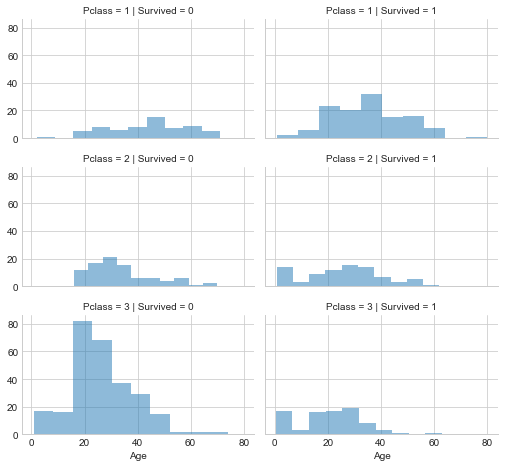

In [364]:
grid = sns.FacetGrid(df_train, col='Survived', row='Pclass', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=10)
grid.add_legend()

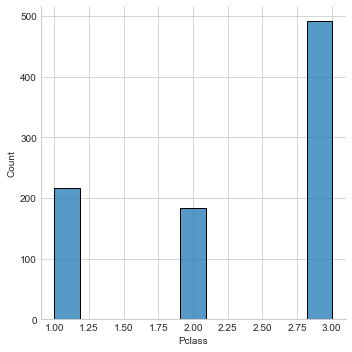

In [365]:
sns.displot(df_train.Pclass)

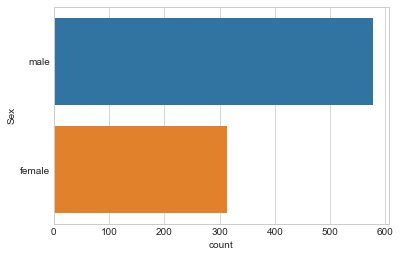

In [366]:
sns.countplot(y="Sex", data=df_train);

C:\Users\meghe\anaconda3\lib\site-packages\seaborn\axisgrid.py:645: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


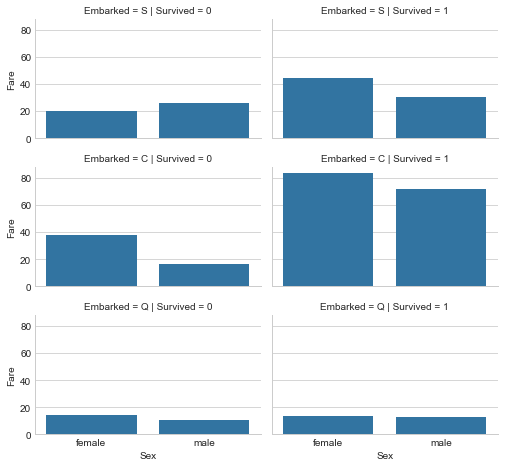

In [367]:
grid = sns.FacetGrid(df_train, row='Embarked', col='Survived', height=2.2, aspect=1.6)
grid.map(sns.barplot,'Sex', 'Fare', alpha=1, ci=None)
grid.add_legend()

Wrangline the data: 

Let's Drop the columns we eliminated during our analysis : 

In [368]:
print("Initially", df_train.shape, df_test.shape)

df_train = df_train.drop(['Ticket', 'Cabin', 'Name', 'PassengerId'], axis=1)
df_test = df_test.drop(['Ticket', 'Cabin', 'Name', 'PassengerId'], axis=1)

print("After Modification", df_train.shape, df_test.shape)

Initially (891, 12) (418, 11)
After Modification (891, 8) (418, 7)


In [369]:
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


Converting Categorical Features into numbers: 

In [370]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_train['Sex'] = le.fit_transform(df_train['Sex'])
df_test['Sex'] = le.fit_transform(df_test['Sex'])

In [371]:
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,S
1,1,1,0,38.0,1,0,71.2833,C
2,1,3,0,26.0,0,0,7.9250,S
3,1,1,0,35.0,1,0,53.1000,S
4,0,3,1,35.0,0,0,8.0500,S


Now let us work towards completing the missing information for some of the features. One solution is to remove those entries and other is to fill it by some guess (mean value maybe...)

Now here the approach we are using to fill the age value will be based upon assigning the random value in between : <br> 
$\mu$ - $\sigma$ to $\mu$ + $\sigma$  

In [372]:
df_both = [df_train, df_test]

In [373]:
df_train['Pclass'].isnull().values.any()

False

In [374]:
df_train['Age'].isnull().values.any()

True

In [375]:
df_train['Age'].isnull().values.any()

True

In [376]:
df_both = [df_train, df_test]

for data in df_both:
    mean_val = df_train["Age"].mean()
    std_val = df_train["Age"].std()
    null_val = data["Age"].isnull().sum()
    # compute random numbers between the mean_val, std_val and null_val
    rand_age = np.random.randint(mean_val - std_val, mean_val + std_val, size = null_val)
    # fill NaN values in Age column with random values generated
    age_slice = data["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    data["Age"] = age_slice
    data["Age"] = df_train["Age"].astype(int)


In [377]:
df_train["Age"].isnull().sum()

0

Now since we are done with Age, lets focus on other missing values. 

In [378]:
df_train["Embarked"].isnull().sum()

2

Now since there are only 2 values out of 891, hence we can assign it to be anything, it will not affect the results much. 

In [379]:
df_train["Embarked"] = df_train["Embarked"].fillna('S')

In [380]:
df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int32  
 3   Age       891 non-null    int32  
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(1), int32(2), int64(4), object(1)
memory usage: 48.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    int32  
 2   Age       418 non-null    int32  
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      417 non-null    float64
 6   Embarked  41

In [381]:
#need to adjust fare in test dataset (only 1 value)
df_test = df_test.fillna(df_test['Fare'].mean())

In [382]:
df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int32  
 3   Age       891 non-null    int32  
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(1), int32(2), int64(4), object(1)
memory usage: 48.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    int32  
 2   Age       418 non-null    int32  
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      418 non-null    float64
 6   Embarked  41

In [383]:
df_test["Embarked"]= LabelEncoder().fit_transform(df_test["Embarked"])
df_train["Embarked"]= LabelEncoder().fit_transform(df_train["Embarked"])


In [384]:
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22,1,0,7.2500,2
1,1,1,0,38,1,0,71.2833,0
2,1,3,0,26,0,0,7.9250,2
3,1,1,0,35,1,0,53.1000,2
4,0,3,1,35,0,0,8.0500,2


Spliting the Train & Test datasets

In [385]:
X_train = df_train.drop("Survived", axis=1)
Y_train = df_train["Survived"]

In [386]:
X_test  = df_test.copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 7), (891,), (418, 7))

Training the Classification model

1. Logistic Regression: 
    

In [399]:
log_reg = LogisticRegression()
log_reg.fit(X_train, Y_train)
Y_pred = log_reg.predict(X_train)
acc_log = round(log_reg.score(X_train, Y_train) * 100, 2)
acc_log


80.81

2. SVM

In [403]:
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

68.24

3. KNN

In [404]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

82.38

4. Gaussian Naive Bayes

In [405]:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

79.24

5. Perceptron

In [406]:
perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

65.66

6. Linear SVC

In [407]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

C:\Users\meghe\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


78.34

7. Stochastic Gradient Descent

In [409]:
sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

70.48

8. Decision Tree 

In [411]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

98.32

9. Random Forest

In [412]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

98.32

In [413]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,98.32
8,Decision Tree,98.32
1,KNN,82.38
2,Logistic Regression,80.81
4,Naive Bayes,79.24
7,Linear SVC,78.34
6,Stochastic Gradient Decent,70.48
0,Support Vector Machines,68.24
5,Perceptron,65.66


Conclusion : Clearly we can see that both Decision Tree and Random Forest can be implemented and the score recieved is also pretty decent.

You'll have a better chance if you're a woman or a child. You have a better chance of surviving if you have a higher class ticket than if you have a third class ticket. In comparison to Southampton or Queenstown, a man is more likely to live if he embarks in Cherbourg. If you travel with 1 or 3 persons instead of 0 or more than 3, your chances of survival increase.